# Install

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 17.6MB/s 


# Evn

In [ ]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [ ]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

Wed Feb  3 03:53:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/data/data'
os.listdir(data_dir)

['ko_32000.model',
 'ko_32000.vocab',
 'kowiki',
 'mycorpus',
 '.ipynb_checkpoints',
 'my_vocab.model',
 'nsmc',
 'quora',
 'songys']

In [ ]:
# korean wiki dir
kowiki_dir = os.path.join(data_dir, 'kowiki')
if not os.path.exists(kowiki_dir):
    os.makedirs(kowiki_dir)
os.listdir(kowiki_dir)

['kowiki.txt.zip', 'kowiki_lm.json', 'lm.csv', 'lm.hdf5']

# Vocabulary & config

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [ ]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 256  # number of sequence
d_model = 256  # dimension of model

# 모델링

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해',
    '나는 오늘 행복해 나는 오늘 즐거워'
]

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

In [ ]:
# 학습용 입력 데이터 생성
train_ids = []
for sentence in sentences:
    train_ids.append([word_to_id[word] for word in sentence.split()])



# id를 입력과 정답으로 저장
train_inputs, train_labels = [], []
for train_id in train_ids:
    train_inputs.append([word_to_id['[BOS]']] + train_id)
    train_labels.append(train_id + [word_to_id['[EOS]']])

# 문장의 길이를 모두 동일하게 변경 (최대길이 8)
for row in train_inputs:
    row += [0] * (8 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 8)
for row in train_labels:
    row += [0] * (8 - len(row))

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_labels = np.array(train_labels)

train_inputs, train_labels

In [ ]:
# 단어를 벡터로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id) , 4)
hidden = embedding(train_inputs)
hidden

In [ ]:
# LSTM 실행
lstm = tf.keras.layers.LSTM(units = 5 , return_sequences = True)
hidden = lstm(hidden)
hidden

<tf.Tensor: shape=(2, 8, 5), dtype=float32, numpy=
array([[[ 0.00319188,  0.0004601 ,  0.00048046,  0.00068459,
          0.00486466],
        [ 0.00894166, -0.00398243, -0.00042938, -0.00316281,
          0.01105411],
        [ 0.00766935, -0.00386156,  0.00388169, -0.00665173,
          0.00903312],
        [ 0.00829616, -0.00536775,  0.00688199, -0.01092444,
          0.01057143],
        [-0.00012326, -0.00511966, -0.00149244, -0.00613498,
         -0.0010604 ],
        [ 0.00606216, -0.00820581, -0.00172402, -0.00856205,
          0.00738286],
        [ 0.00519836, -0.00702938,  0.00313166, -0.01096036,
          0.00693066],
        [ 0.00657915, -0.00800196,  0.00457055, -0.01407604,
          0.00739967]],

       [[ 0.00319188,  0.0004601 ,  0.00048046,  0.00068459,
          0.00486466],
        [ 0.00894166, -0.00398243, -0.00042938, -0.00316281,
          0.01105411],
        [ 0.00766935, -0.00386156,  0.00388169, -0.00665173,
          0.00903312],
        [ 0.00388655, -

In [ ]:
# 다음단어 예측
dense = tf.keras.layers.Dense(len(word_to_id), activation = tf.nn.softmax)
outputs = dense(hidden)
outputs

<tf.Tensor: shape=(2, 8, 11), dtype=float32, numpy=
array([[[0.09095009, 0.09100534, 0.09078809, 0.09107333, 0.09073468,
         0.09084196, 0.09071952, 0.0911459 , 0.09077941, 0.09089004,
         0.09107161],
        [0.09091932, 0.0908605 , 0.09085783, 0.09155371, 0.09053011,
         0.09105469, 0.09082662, 0.09110866, 0.0907365 , 0.09049691,
         0.09105515],
        [0.0910784 , 0.09098901, 0.09074864, 0.09155462, 0.090539  ,
         0.09118763, 0.09117985, 0.09108083, 0.09056233, 0.09015973,
         0.09091996],
        [0.09113628, 0.09101795, 0.09070639, 0.09178611, 0.09049145,
         0.09136044, 0.0914659 , 0.09108679, 0.0903735 , 0.08977969,
         0.0907955 ],
        [0.09075198, 0.09058631, 0.09120022, 0.09120046, 0.09101953,
         0.09125873, 0.09135398, 0.0905164 , 0.0910138 , 0.09051464,
         0.09058393],
        [0.09073099, 0.09053629, 0.0911767 , 0.09170382, 0.09075757,
         0.09136692, 0.09129173, 0.09067336, 0.09086999, 0.09021923,
         0

In [ ]:
def build_model(n_vocab, d_model, n_seq):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장 길이 (단어 수)
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    #######################################################
    embedding = tf.keras.layers.Embedding(n_vocab , d_model)
    hidden = embedding(inputs)
    hidden

    lstm = tf.keras.layers.LSTM(units = 512 , return_sequences = True)
    hidden = lstm(hidden)

    dense = tf.keras.layers.Dense(n_vocab, activation = tf.nn.softmax)
    outputs = dense(hidden)

    #######################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

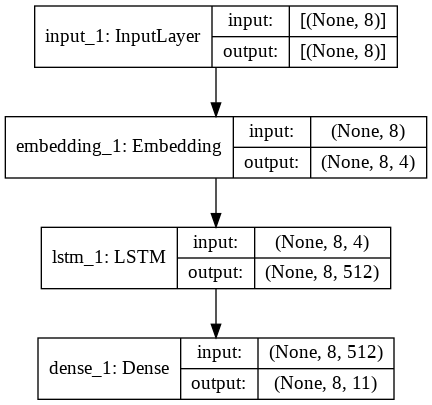

In [ ]:
# 모델 생성
model = build_model(len(word_to_id), 4, 8)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Preprocessing


In [ ]:
# 파일 내용 확인
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
    with z.open('kowiki.txt') as f:
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            print(line)
            if i >= 100:
                break

지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
1976년 미합중국 (미국) 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 (당시 미국 대통령) 를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.
카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 1980년 하계 올림픽에 반공국가들의 보이콧

In [ ]:
# 파일 내용 확인 (주제단위)
with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
    with z.open('kowiki.txt') as f:
        doc = []
        for i, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if len(line) == 0:
                if len(doc) > 0:
                    break
            else:
                doc.append(line)
doc

['지미 카터',
 '제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.',
 '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.',
 '1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.',
 '1976년 미합중국 (미국) 제39대 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워서, 많은 지지를 받고 제럴드 포드 (당시 미국 대통령) 를 누르고 당선되었다.',
 '카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.',
 '카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.',
 '그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제2차 전략 무기 제한 협상에 조인했다.',
 '카터는 1970년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.',
 '그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 1980년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니

In [ ]:
def create_train_instance(vocab, n_seq, doc):
    """
    create train instance
    :param vocab: vocabulary object
    :param n_seq: sequece number
    :param doc: wiki document
    :return: train instance list
    """
    n_max = n_seq - 1
    instance_list = []

    chunk = []
    chunk_len = 0
    for i, line in enumerate(doc):
        ##################################
        # print(line)
        tokens = vocab.encode_as_pieces(line)
        chunk.append(tokens)
        chunk_len += len(tokens)
        if n_max <= chunk_len or i >= len(doc) -1:
            # print()
            # print(chunk_len, chunk)
            # 문장의 배열을 하나의 배열로 변경
            instance = []
            for tokens in chunk:
                instance.extend(tokens)
            # 길이가 긴 경우 길이를 자름
            instance = instance[:n_max]
            # print(len(instance), instance)
            # instance 저장
            instance_list.append(instance)
            # chunk 초기화
            chunk = []
            chunk_len = 0
        ##################################
    return instance_list

In [ ]:
# instance 동작 확인
instance_list = create_train_instance(vocab, n_seq, doc)
for instance in instance_list:
    print(len(instance), instance)

255 ['▁지미', '▁카터', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아', '▁주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의원', '을'

In [ ]:
# instance를 json 형태로 저장하는 함수
def save_instance(vocab, n_seq, doc, o_f):
    instance_list = create_train_instance(vocab, n_seq, doc)
    for instance in instance_list:
        o_f.write(json.dumps({'token': instance}, ensure_ascii=False))
        o_f.write('\n')

In [ ]:
# 전체 문서에 대한 instance 생성
with open(os.path.join(kowiki_dir, 'kowiki_lm.json'), 'w') as o_f:
    with zipfile.ZipFile(os.path.join(kowiki_dir, 'kowiki.txt.zip')) as z:
        with z.open('kowiki.txt') as f:
            doc = []
            for i, line in enumerate(tqdm(f)):
                line = line.decode('utf-8').strip()
                if len(line) == 0:
                    if len(doc) > 0:
                        save_instance(vocab, n_seq, doc, o_f)
                        doc = []
                        #break
                else:
                    doc.append(line)
            if len(doc) > 0:
                save_instance(vocab, n_seq, doc, o_f)

In [ ]:
# 파일 라인수 확인
n_line = 0
with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
    for line in f:
        n_line += 1
        if n_line <= 10:
            print(line)
n_line

{"token": ["▁지미", "▁카터", "▁제임스", "▁얼", "▁\"", "지", "미", "\"", "▁카터", "▁주니어", "(", ",", "▁1924", "년", "▁10", "월", "▁1", "일", "▁~", "▁)", "는", "▁민주당", "▁출신", "▁미국", "▁39", "대", "▁대통령", "▁", "(1977", "년", "▁~", "▁1981", "년", ")", "이다", ".", "▁지미", "▁카터", "는", "▁조지아주", "▁섬", "터", "▁카운티", "▁플레", "인", "스", "▁마을에서", "▁태어났다", ".", "▁조지아", "▁공과대학교", "를", "▁졸업하였다", ".", "▁그", "▁후", "▁해군", "에", "▁들어가", "▁전함", "·", "원자력", "·", "잠수함", "의", "▁승무원", "으로", "▁일", "하였다", ".", "▁1953", "년", "▁미국", "▁해군", "▁대위", "로", "▁예편", "하였고", "▁이후", "▁땅콩", "·", "면", "화", "▁등을", "▁가", "꿔", "▁많은", "▁돈을", "▁벌", "었다", ".", "▁그의", "▁별명이", "▁\"", "땅", "콩", "▁농부", "\"", "▁(", "P", "ean", "ut", "▁F", "ar", "mer", ")", "로", "▁알려졌다", ".", "▁1962", "년", "▁조지아", "▁주", "▁상원", "▁의원", "▁선거에서", "▁낙선", "하나", "▁그", "▁선거", "가", "▁부정", "선거", "▁", "였", "음을", "▁입증", "하게", "▁되어", "▁당선", "되고", ",", "▁1966", "년", "▁조지아", "▁주", "▁지사", "▁선거에", "▁낙선", "하지만", "▁1970", "년", "▁조지아", "▁주", "▁지사", "를", "▁역임했다", ".", "▁대통령이", "▁되기", "▁전", "▁조지아주", "▁

778381

# Sample Data Project

## Data


In [ ]:
def load_data(vocab, n_seq):
    """
    Language Model 학습 데이터 생성
    :param vocab: vocabulary object
    :param n_seq: number of sequence
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    # line 수 조회
    # n_line = 0
    # with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
    #     for line in f:
    #         n_line += 1
    # 10개로 제한
    n_data = 10
    # 빈 데이터 생성
    inputs = np.zeros((n_data, n_seq)).astype(np.int32)
    labels = np.zeros((n_data, n_seq)).astype(np.int32)

    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for i, line in enumerate(f):
            if i >= n_data:
                break
            ##################################
            data = json.loads(line)
            print()
            print(data)
            token_id = [vocab.piece_to_id(p) for p in data['token']]
            print(len(token_id), token_id)
            # input id
            input_id = [vocab.bos_id()] + token_id
            input_id += [0] * (n_seq - len(input_id))
            print(len(input_id), input_id)
            # label id
            label_id = token_id + [vocab.eos_id()]
            label_id += [0] * (n_seq - len(label_id))
            print(len(label_id), label_id)
            # 값 저장
            inputs[i] = input_id
            labels[i] = label_id
            ##################################

    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(vocab, n_seq)
train_inputs, train_labels


{'token': ['▁지미', '▁카터', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(', ',', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '대', '▁대통령', '▁', '(1977', '년', '▁~', '▁1981', '년', ')', '이다', '.', '▁지미', '▁카터', '는', '▁조지아주', '▁섬', '터', '▁카운티', '▁플레', '인', '스', '▁마을에서', '▁태어났다', '.', '▁조지아', '▁공과대학교', '를', '▁졸업하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전함', '·', '원자력', '·', '잠수함', '의', '▁승무원', '으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대위', '로', '▁예편', '하였고', '▁이후', '▁땅콩', '·', '면', '화', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별명이', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '▁알려졌다', '.', '▁1962', '년', '▁조지아', '▁주', '▁상원', '▁의원', '▁선거에서', '▁낙선', '하나', '▁그', '▁선거', '가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '▁조지아', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '▁주', '▁지사', '를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아주', '▁상원의

(array([[    2, 14473, 14639, ...,    24,   112,  6087],
        [    2,   138,   931, ...,   167,  8945,    59],
        [    2, 12780,    82, ...,    16,  2194,    43],
        ...,
        [    2, 25180,    18, ...,   143,   467,   603],
        [    2, 17718,    94, ...,   269,     8,   314],
        [    2,  2337,     9, ...,     0,     0,     0]], dtype=int32),
 array([[14473, 14639,  2033, ...,   112,  6087,     3],
        [  138,   931,  6428, ...,  8945,    59,     3],
        [12780,    82,  3392, ...,  2194,    43,     3],
        ...,
        [25180,    18, 19486, ...,   467,   603,     3],
        [17718,    94,  9601, ...,     8,   314,     3],
        [ 2337,     9, 12386, ...,     0,     0,     0]], dtype=int32))

## Loss & Acc

In [ ]:
# 4개 의 단어를 예측하기 위한 정답과 예측값 가정
# 정답
y_true = np.random.randint(1, 3, (1, 20)).astype(np.float32)
y_true[:, 8:] = 0
# 예측 값
y_pred = np.random.random((1, 20, 4)).astype(np.float32)
y_pred = tf.nn.softmax(y_pred, axis=-1).numpy()  # 확률 값으로 변경

y_true, y_pred

(array([[2., 2., 1., 2., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32),
 array([[[0.2014149 , 0.2324197 , 0.27894443, 0.28722093],
         [0.24675597, 0.2986718 , 0.28180978, 0.17276245],
         [0.27507097, 0.30699873, 0.18292724, 0.23500307],
         [0.15437317, 0.20702004, 0.36399195, 0.2746149 ],
         [0.21794164, 0.3223877 , 0.20111176, 0.25855884],
         [0.3259501 , 0.21140808, 0.3048331 , 0.15780872],
         [0.25889552, 0.2589785 , 0.15932654, 0.32279947],
         [0.24688564, 0.39390135, 0.16844237, 0.1907706 ],
         [0.1605852 , 0.30077136, 0.27757582, 0.26106766],
         [0.17876586, 0.30012107, 0.23803584, 0.2830772 ],
         [0.19547004, 0.32076427, 0.3078022 , 0.17596354],
         [0.20055635, 0.26928666, 0.23845431, 0.29170266],
         [0.32548183, 0.2754673 , 0.1659615 , 0.23308928],
         [0.30148587, 0.22730768, 0.27395034, 0.19725612],
         [0.2416972 , 0.41077355, 0.17416099, 0.17336829],

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
    sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    loss = sparse_entropy(y_true, y_pred)
    # mask 계산
    # print(y_true)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [ ]:
# lm_loss 함수 확인
loss = lm_loss(y_true, y_pred)
print(loss)

tf.Tensor(
[[1.2767426 1.266523  1.1809117 1.0106235 1.1320004 1.553965  1.3510103
  1.7811615 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.       ]], shape=(1, 20), dtype=float32)


In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    #print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    #print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    #print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    #print(mask)
    matches *= mask
    #print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

In [ ]:
# lm_acc 함수 확인
accuracy = lm_acc(y_true, y_pred)
print(accuracy)

tf.Tensor(0.375, shape=(), dtype=float32)


## 학습

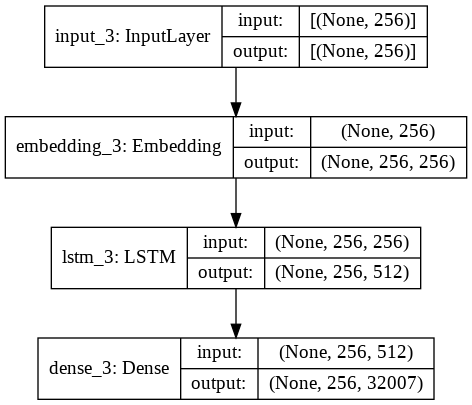

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 'lm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'lm.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    epochs=500,
                    batch_size=128,
                    callbacks=[early_stopping, save_weights, csv_logger])

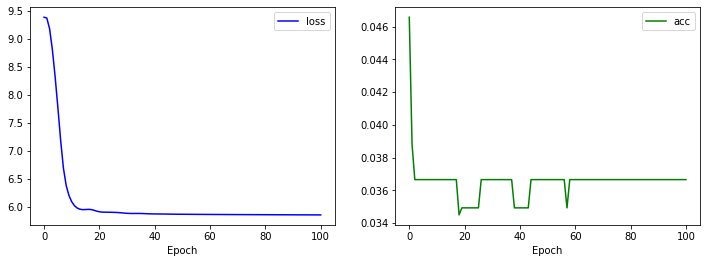

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# train weight로 초기화
model.load_weights(os.path.join(kowiki_dir, 'lm.hdf5'))

In [ ]:
def do_next(vocab, model, n_seq, string):
    """
    다음단어 예측
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence == 256
    :param string: inpust string == 입력값
    """
    n_max = n_seq - 1
    
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    print(start_idx, ':' , token_id)



    ###################################
    result = model.predict(np.array([token_id]))
    print(result.shape)
    prob = result[0][start_idx]
    print(prob)


    # 정렬 (작 --> 큰)
    max_args = np.argsort(prob)[-10:]
    print(max_args)
    max_args = list(max_args)
    # 정렬 (큰 --> 작)
    max_args.reverse()
    print(max_args)

    next_prob = []
    

    for i in max_args:
      w = vocab.id_to_piece(int(i))
      p = prob[i]

      next_prob.append((w, p))

    ###################################
    return next_prob

In [ ]:
string = '수학공부,'
do_next(vocab, model, n_seq, string)

4 : [2, 2337, 281, 106, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(1, 256, 32007)
[2.1461199e-08 8.1243252e-06 2.1963579e-08 ... 3.6363637e-08 5.4451693e-08
 1.4873453e-08]
[ 186 1080  521  232  172   29   41   49  462   10]
[10, 462, 49, 41, 29, 172, 232, 521, 1080, 186]


[('▁', 0.011663915),
 ('▁즉', 0.00987188),
 ('▁《', 0.009142098),
 ('▁제', 0.008249118),
 ('▁이', 0.0076202755),
 ('▁그리고', 0.0070894947),
 ('▁성', 0.0060673445),
 ('▁박', 0.0050638947),
 ('▁기독교', 0.0041684126),
 ('▁신', 0.004144423)]

In [ ]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    next_prob = do_next(vocab, model, n_seq, string)
    for w, p in next_prob:
        print(f'{w}: {p}')
    print()

In [ ]:
def do_generate(vocab, model, n_seq, string):
    """
    문장생성
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    for _ in range(start_idx, n_seq -1):
        print(token_id)
        #########################################
        outputs = model.predict(np.array([token_id]))
        prob = outputs[0][start_idx]
        word_id = int(np.argmax(prob))
        # word_id = int(np.random.choice(len(vocab), 1, p=prob)[0])
        if word_id == vocab.eos_id():
            break
        token_id[start_idx + 1] = word_id
        start_idx += 1 
        #########################################
    predict_id = token_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
string = '대한민국'
do_generate(vocab, model, n_seq, string)

In [ ]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_generate(vocab, model, n_seq, string)
    print(predict_str)

# All Data Project

## Data


In [ ]:
def load_data(vocab, n_seq):
    """
    Language Model 학습 데이터 생성
    :param vocab: vocabulary object
    :param n_seq: number of sequence
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    # line 수 조회
    n_line = 0
    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for line in f:
            n_line += 1
    # 최대 100,000개 데이터
    n_data = min(n_line, 100000)
    # 빈 데이터 생성
    inputs = np.zeros((n_data, n_seq)).astype(np.int32)
    labels = np.zeros((n_data, n_seq)).astype(np.int32)

    with open(os.path.join(kowiki_dir, 'kowiki_lm.json')) as f:
        for i, line in enumerate(tqdm(f, total=n_data)):
            if i >= n_data:
                break
            data = json.loads(line)
            token_id = [vocab.piece_to_id(p) for p in data['token']]
            # input id
            input_id = [vocab.bos_id()] + token_id
            input_id += [0] * (n_seq - len(input_id))
            # label id
            label_id = token_id + [vocab.eos_id()]
            label_id += [0] * (n_seq - len(label_id))
            # 값 저장
            inputs[i] = input_id
            labels[i] = label_id

    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(vocab, n_seq)
train_inputs, train_labels

(array([[    2, 14473, 14639, ...,    24,   112,  6087],
        [    2,   138,   931, ...,   167,  8945,    59],
        [    2, 12780,    82, ...,    16,  2194,    43],
        ...,
        [    2,  7635,    47, ...,  8202,    16,   857],
        [    2, 22576,   156, ..., 17847,     1,  1030],
        [    2,   325, 14342, ...,    89,    23,   628]], dtype=int32),
 array([[14473, 14639,  2033, ...,   112,  6087,     3],
        [  138,   931,  6428, ...,  8945,    59,     3],
        [12780,    82,  3392, ...,  2194,    43,     3],
        ...,
        [ 7635,    47, 10990, ...,    16,   857,     3],
        [22576,   156,  9254, ...,     1,  1030,     3],
        [  325, 14342,  9766, ...,    23,   628,     3]], dtype=int32))

## Loss & Acc

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return loss

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    matches *= mask
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

## 학습

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=50)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(kowiki_dir, 'lm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(kowiki_dir, 'lm.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    epochs=2,
                    batch_size=64,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq)
# train weight로 초기화
model.load_weights(os.path.join(kowiki_dir, 'lm.hdf5'))

In [ ]:
def do_next(vocab, model, n_seq, string):
    """
    다음단어 예측
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    result = model.predict(np.array([token_id]))
    prob = result[0][start_idx]
    max_args = np.argsort(prob)[-10:]
    max_args = list(max_args)
    max_args.reverse()

    next_prob = []
    for i in max_args:
        w = vocab.id_to_piece(int(i))
        p = prob[i]
        next_prob.append((w, p))
    return next_prob

In [ ]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    next_prob = do_next(vocab, model, n_seq, string)
    for w, p in next_prob:
        print(f'{w}: {p}')
    print()

시작 문장 > 대한민국
▁헌법: 0.04839080572128296
▁정부는: 0.030647622421383858
은: 0.02273130975663662
▁제: 0.01919873058795929
▁정부: 0.01393178105354309
▁최초의: 0.01276386622339487
▁국군: 0.011495193466544151
▁국방부: 0.010004623793065548
▁국회: 0.009308043867349625
▁내: 0.007775578647851944

시작 문장 > 


In [ ]:
def do_generate(vocab, model, n_seq, string):
    """
    문장생성
    :param vocab: vocab
    :param model: model
    :param n_seq: number of seqence
    :param string: inpust string
    """
    n_max = n_seq - 1
    tokens = vocab.encode_as_pieces(string)
    start_idx = len(tokens)
    token_id = [vocab.piece_to_id(p) for p in tokens][:n_max]
    token_id = [vocab.bos_id()] + token_id
    token_id += [0] * (n_seq - len(token_id))
    assert len(token_id) == n_seq

    for _ in range(start_idx, n_seq - 1):
        outputs = model.predict(np.array([token_id]))
        prob = outputs[0][start_idx]
        word_id = int(np.random.choice(len(vocab), 1, p=prob)[0])
        # word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        token_id[start_idx + 1] = word_id
        start_idx += 1
    predict_id = token_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
while True:
    string = input('시작 문장 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_generate(vocab, model, n_seq, string)
    print(predict_str)

시작 문장 > 대학민국
대학민국(直izwan Konget School,0819 3214(敎育빌, 1982년 1941년)은 퇴임 전까지 대한민국의 아일랜드고산의 배급상을共皇帝 호적과 호암에 있는 박청메이로의 중국 반민특위에 의한 위반, 위생 무렵부터 확정, 법문화에 관한 시도 소식이다. 제헌사관학교 재직중에 1941년 4월 종교개혁 운동이 추서되었다. 1945년 경남민주화운동 당시 수립 후 정주동안을 이끌고 미군정 임시정부 관할 주관권연합회 거래나가 관리권을 거두었다. 1961년 3월 3일 일본에 세 애국공동 보좌관 재직 국가 백악관 및 파업의 복무를 정부는 ‘중국군의 고객 졸업서’를 발표하였다. 이에 있다. 함경남도 선옥원(金順/院許樞大政院將團)
시작 문장 > 대학교
대학교는 신돌과 무도하다. 권총은 만화가 중이다. 잠시 서울 국무총리 제5봉총리 51번지 - 이재석 구간 - 박종하, 철새 고시학, 본인, 색대석, 안경철 등과 함께 배송형으로 선정되기도 하였다. 1994년 미국 첫 28세이브를 계기로 이적은 구속 혜택이 오스동고를내야 하였다. 안산고등학교 계열 평환단 예하의 방송사에 있는 제 2회 공식국민학교의 회번선이 비중만 익산호텔(), 돌연 부산-중대 전 제평·3 출생기, 평양 도쿠시마 계룡 가맹구 아시아간 용일원에 진학한 춘추 정부에서 첫 데뷔하였고, 이 필란이 교회를 단행할 것 당시 일립학생인 북한에 영감을 끼치게 여긴 것이다. 2000년대 초반에 매년 국회에서부터 별다른 중간에는 2018년 성리학이 신평색과 대북 영화가 수단으로 어렸을 제안을 고안하였으며, 실제 거북망을 참고 한다는 주장이 있다. 하지만 교회는 특정 국가보조의 지배를 받았다. 광주투데이 어음악장(VDP)가 각지도 분리했던 강이 여포가 항공사 중 약 84위나 자천·8.5·측재의 전주 제 2조에도 가능하도록 삼드나 수구암(瓦天死聖橋)의 개통되어, 곽문충(
시작 문장 > 국무총리
국무총리가 심정겐(任奴閣)에 있는 전도가 정규면을 따라간다. 중 2,3가 된 3 °27 반대에 당선되었기 때문이